# Libraries

In [ ]:
!pip install yfinance

In [ ]:
# to load the desired data
import yfinance as yf

# needed libraries in general
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Bidirectional
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Loading the Dataset

In [ ]:
data = yf.download('AMZN', start='2000-01-01', end='2022-12-31')

[*********************100%%**********************]  1 of 1 completed


# Data analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5787 entries, 2000-01-03 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5787 non-null   float64
 1   High       5787 non-null   float64
 2   Low        5787 non-null   float64
 3   Close      5787 non-null   float64
 4   Adj Close  5787 non-null   float64
 5   Volume     5787 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 316.5 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
1,2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2,2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
3,2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
4,2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [ ]:
# the date column is set as an index not a column
data.reset_index(inplace=True)
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# checking again for null values
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
# target column distribution
data['Adj Close'].describe()

count    5787.000000
mean       34.303404
std        49.417387
min         0.298500
25%         2.200250
50%         9.294500
75%        44.451250
max       186.570496
Name: Adj Close, dtype: float64

<Axes: >

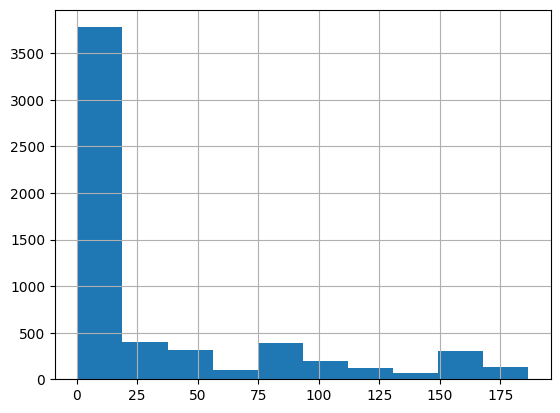

In [ ]:
# skewed to the right
data['Adj Close'].hist()

In [ ]:
# duplicates
data.duplicated().any()

False

# Data Preprocessing

In [ ]:
# Extract the 'Date' and 'Adj price'
dates = data['Date'].astype(object)
prices = data['Adj Close']

In [ ]:
# data to feed to our model
data_array = np.column_stack((dates, prices))

In [ ]:
# example
data_array

array([[Timestamp('2000-01-03 00:00:00'), 4.46875],
       [Timestamp('2000-01-04 00:00:00'), 4.096875190734863],
       [Timestamp('2000-01-05 00:00:00'), 3.487499952316284],
       ...,
       [Timestamp('2022-12-28 00:00:00'), 81.81999969482422],
       [Timestamp('2022-12-29 00:00:00'), 84.18000030517578],
       [Timestamp('2022-12-30 00:00:00'), 84.0]], dtype=object)

In [ ]:
import datetime

# Assuming 'dates' and 'prices' are NumPy arrays
data_array = np.column_stack((dates, prices))

# Convert the 'Date' column to datetime
data_df = pd.DataFrame(data_array)
data_df.iloc[:, 0] = pd.to_datetime(data_df.iloc[:, 0]).dt.date

# Convert the dates to Unix timestamps
data_df.iloc[:, 0] = [datetime.datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S').timestamp() for date in data_df.iloc[:, 0]]

# If you want to convert the timestamps back to numpy array
data_array = data_df.values

In [ ]:
# after converting the date to unix time stamp
data_array

array([[946857600.0, 4.46875],
       [946944000.0, 4.096875190734863],
       [947030400.0, 3.487499952316284],
       ...,
       [1672185600.0, 81.81999969482422],
       [1672272000.0, 84.18000030517578],
       [1672358400.0, 84.0]], dtype=object)

In [ ]:
data_array.shape

(5787, 2)

In [ ]:
# spliting the dataset into training and testing sets
train_size = int(len(data_array)*0.7)
train, test = data_array[0:train_size], data_array[train_size:]

In [ ]:
# example
train

array([[946857600.0, 4.46875],
       [946944000.0, 4.096875190734863],
       [947030400.0, 3.487499952316284],
       ...,
       [1454544000.0, 26.812999725341797],
       [1454630400.0, 25.10650062561035],
       [1454889600.0, 24.405000686645508]], dtype=object)

In [ ]:
# example
test

array([[1454976000.0, 24.103500366210938],
       [1455062400.0, 24.52400016784668],
       [1455148800.0, 25.19099998474121],
       ...,
       [1672185600.0, 81.81999969482422],
       [1672272000.0, 84.18000030517578],
       [1672358400.0, 84.0]], dtype=object)

In [ ]:
print(train.shape)
print(test.shape)

(4050, 2)
(1737, 2)


In [ ]:
# Separate the 'Date' and 'Price' columns for normalization
train_dates, train_prices = train[:, 0], train[:, 1].astype(float)  # Convert 'Price' to float
test_dates, test_prices = test[:, 0], test[:, 1].astype(float)  # Convert 'Price' to float


In [ ]:
# Normalize only the 'Price' data
# The goal of normalization is to transform features to be on a similar scale. This improves the performance and training stability of the model.
scaler_price = MinMaxScaler()
train_prices_scaled = scaler_price.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler_price.transform(test_prices.reshape(-1, 1))

In [ ]:
# Combine the 'Date' and scaled 'Price' columns back into the dataset
# why flatten --> to transform the input data into a format that can be easily understood and processed by the neural network.
train_scaled = np.column_stack((train_dates, train_prices_scaled.flatten()))
test_scaled = np.column_stack((test_dates, test_prices_scaled.flatten()))

In [ ]:
# used to transform a time series dataset into a format suitable for supervised learning,
# particularly for sequence prediction tasks
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 1]  # Use index 1 for 'Price'
        X.append(a)
        y.append(dataset[i + time_steps, 1])
    return np.array(X), np.array(y)


In [ ]:
# Set the time steps
time_steps = 30

# Create the time series dataset for training
X_train, y_train = create_dataset(train_scaled, time_steps)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype('float32')

# Create the time series dataset for testing
X_test, y_test = create_dataset(test_scaled, time_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')

In [ ]:
# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

# LSTM

In [ ]:
# Buliding the LSTM model
model_lstm = Sequential() # defining the model
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # adding the first LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=False)) # Second
model_lstm.add(Dense(units=1, activation='relu')) # third
model_lstm.compile(optimizer='adam', loss='mean_squared_error') # output layer

In [ ]:
# Train the model
# first time epoch = 25
history_lstm=model_lstm.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
126/126 [==============================] - 10s 39ms/step - loss: 0.0028
Epoch 2/25
126/126 [==============================] - 4s 29ms/step - loss: 2.1744e-04
Epoch 3/25
126/126 [==============================] - 4s 29ms/step - loss: 1.9719e-04
Epoch 4/25
126/126 [==============================] - 5s 42ms/step - loss: 2.0663e-04
Epoch 5/25
126/126 [==============================] - 4s 29ms/step - loss: 2.0668e-04
Epoch 6/25
126/126 [==============================] - 4s 29ms/step - loss: 1.6170e-04
Epoch 7/25
126/126 [==============================] - 4s 33ms/step - loss: 1.9126e-04
Epoch 8/25
126/126 [==============================] - 5s 37ms/step - loss: 1.6352e-04
Epoch 9/25
126/126 [==============================] - 4s 30ms/step - loss: 1.4364e-04
Epoch 10/25
126/126 [==============================] - 4s 30ms/step - loss: 1.4774e-04
Epoch 11/25
126/126 [==============================] - 5s 43ms/step - loss: 1.5013e-04
Epoch 12/25
126/126 [==============================] - 

In [ ]:
# predicting on the test data
predicted_prices_lstm = model_lstm.predict(X_test)
type(predicted_prices_lstm)

54/54 [==============================] - 1s 25ms/step


numpy.ndarray

In [ ]:
# Evaluate the model on the testing dataset
loss_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)

print(f"Mean Squared Error (MSE) on Testing Data: {loss_lstm}")

Mean Squared Error (MSE) on Testing Data: 0.3872571289539337


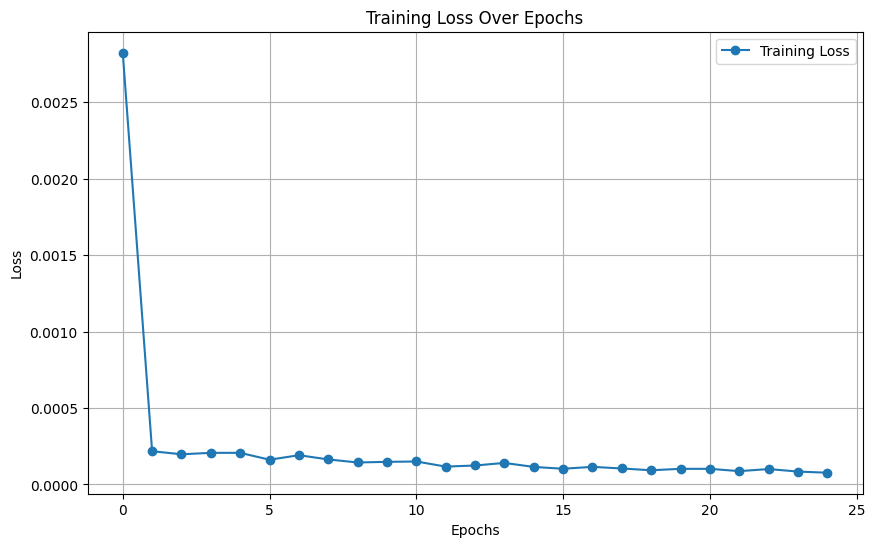

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(history_lstm.history['loss'], label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optionally add a grid for better readability
plt.show()


In [ ]:
history_lstm.history.keys()

dict_keys(['loss'])

In [ ]:
# Inverse transform the testing dataset for plotting
y_test_inverse = scaler_price.inverse_transform(y_test.reshape(-1, 1))
predicted_prices_inv_lstm = scaler_price.inverse_transform(predicted_prices_lstm)

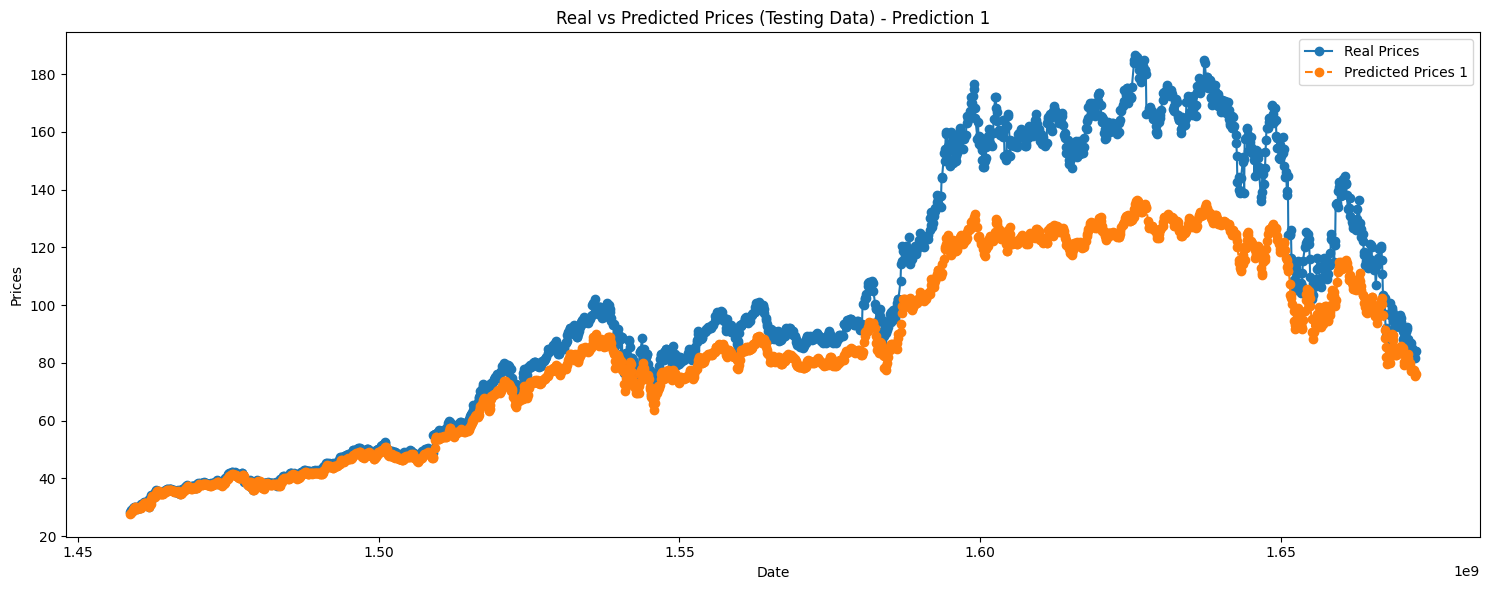

In [ ]:
# Plotting the real and predicted patterns for the testing data
num_predictions = predicted_prices_inv_lstm.shape[1]

plt.figure(figsize=(15, 6 * num_predictions))

for i in range(num_predictions):
    plt.subplot(num_predictions, 1, i + 1)

    # Plotting the real prices
    plt.plot(test_scaled[:, 0][time_steps:], y_test_inverse, label='Real Prices', marker='o')

    # Plotting the predicted prices for the current prediction
    plt.plot(test_scaled[:, 0][time_steps:], predicted_prices_inv_lstm[:, i], label=f'Predicted Prices {i + 1}', linestyle='dashed', marker='o')

    plt.title(f'Real vs Predicted Prices (Testing Data) - Prediction {i + 1}')
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation metrics
# Make predictions on the test set
y_pred = model_lstm.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

54/54 [==============================] - 1s 19ms/step
Mean Squared Error (MSE): 0.39441368
Mean Absolute Error (MAE): 0.45831162
R-squared (R2) Score: 0.775612874509606


# Bi-directional lstm

In [ ]:
#build the model
bi_lstm = Sequential()
bi_lstm.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(X_train.shape[1], 1)))
bi_lstm.add(Dense(units=1, activation='relu'))
bi_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history_bi_lstm = bi_lstm.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
126/126 [==============================] - 4s 28ms/step - loss: 8.7874e-05
Epoch 2/25
126/126 [==============================] - 3s 23ms/step - loss: 9.8729e-05
Epoch 3/25
126/126 [==============================] - 4s 33ms/step - loss: 7.9827e-05
Epoch 4/25
126/126 [==============================] - 4s 28ms/step - loss: 7.8061e-05
Epoch 5/25
126/126 [==============================] - 3s 24ms/step - loss: 7.7633e-05
Epoch 6/25
126/126 [==============================] - 3s 23ms/step - loss: 7.4968e-05
Epoch 7/25
126/126 [==============================] - 6s 52ms/step - loss: 8.1928e-05
Epoch 8/25
126/126 [==============================] - 3s 23ms/step - loss: 7.5970e-05
Epoch 9/25
126/126 [==============================] - 3s 24ms/step - loss: 7.6051e-05
Epoch 10/25
126/126 [==============================] - 3s 23ms/step - loss: 7.9522e-05
Epoch 11/25
126/126 [==============================] - 4s 33ms/step - loss: 7.1484e-05
Epoch 12/25
126/126 [==============================]

In [ ]:
test_predictions_scaled_bi = bi_lstm.predict(X_test)
test_predictions_bi = scaler_price.inverse_transform(test_predictions_scaled_bi)
y_test_inverse = scaler_price.inverse_transform(y_test.reshape(-1, 1))

54/54 [==============================] - 1s 9ms/step


In [ ]:
# Evaluation metrics
# Make predictions on the test set
y_pred = bi_lstm.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

54/54 [==============================] - 0s 8ms/step
Mean Squared Error (MSE): 0.57541794
Mean Absolute Error (MAE): 0.54308444
R-squared (R2) Score: 0.6726371608886528


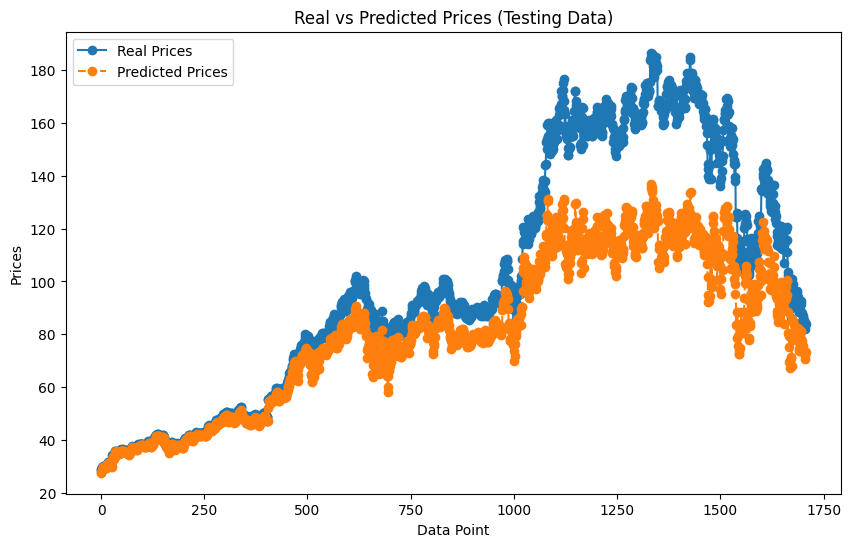

In [ ]:
# Plotting the real and predicted patterns for the testing data
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Real Prices', linestyle='-', marker='o')
plt.plot(test_predictions_bi, label='Predicted Prices', linestyle='dashed', marker='o')
plt.title('Real vs Predicted Prices (Testing Data)')
plt.xlabel('Data Point')
plt.ylabel('Prices')
plt.legend()
plt.show()

# ESN

In [ ]:
!pip install ESN

In [ ]:
import ESN

In [ ]:
train_input, train_output = train_prices_scaled[:-1], train_prices_scaled[1:]

In [ ]:
train_input.shape , train_output.shape

((4049, 1), (4049, 1))

In [ ]:
esn = ESN(n_inputs=train_input.shape[1], n_outputs=train_output.shape[1], n_reservoir=1000,spectral_radius=0.9)

In [ ]:
# Train the ESN
esn.fit(train_input, train_output)

In [ ]:
#predict using ESN
test_predictions_scaled_esn = esn.predict(y_test)


# Inverse transform the predicted prices
test_predictions_esn = scaler_price.inverse_transform(test_predictions_scaled_esn.reshape(-1, 1))


In [ ]:
test_prices = scaler_price.inverse_transform(test_prices_scaled[1:].reshape(-1, 1))

# Compute Mean Squared Error for testing
test_mse = mean_squared_error(y_test, test_predictions_esn)
print(f'Mean Squared Error on Testing Data: {test_mse}')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real Prices', marker='o', linestyle='-')
plt.plot(test_predictions_esn, label='Predicted Prices', linestyle='dashed', marker='o')
plt.title('Real vs Predicted Prices (Testing Data)')
plt.xlabel('Data Point')
plt.ylabel('Prices')
plt.legend()
plt.show()